# Exercise Sheet 6: Autoencoder

In [6]:
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import random
import time

# Import PyTorch
import torch 
import torch.nn as nn

# Load FashionMNIST dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# set figure size
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [8]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
EPOCHS = 30
EPOCHS_NOISE = 30
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
LEARNING_RATE = 1e-3
MOMENTUM = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


### Utility Functions and Classes

In [9]:
def to_img(x, shape=(28, 28)):
    """ Maps a 2D tensor from range [-1, 1] to 4D tensor with range [0, 1].
    Useful for plotting of reconstructions.

    :param x: 2D Tensor that is supposed to be converted
    :return: Converted 4D Tensor with b, c, w, h, where w = h = 28
    """
    x = 0.5 * (x + 1) # mode to range [0, 1]
    x = x.clamp(0, 1) # clip boundaries
    x = x.view(x.size(0), 1, shape[0], shape[1]) # reshape
    return x


def add_white_noise(x, factor=0.5, stddev=1):
    """ Adds white noise to an input tensor.
    To make sure that data is in intended range [min, max], use torch.clamp(x, min, max) after applying this function.

    :param x: ND Tensor that is altered
    :param factor: A factor that controls the strength of the additive noise
    :param stddev: The stddev of the normal distribution used for generating the noise
    :return: ND Tensor, x with white noise
    """
    # add white noise to tensor
    noise = torch.randn_like(x) * stddev
    return x + (noise * factor)

#### Data Preparation

In [10]:
train_mean, train_std = (0.5,), (0.5,)

# Load FashionMNIST dataset & apply transformations for noisy and clean data
# Define a transform to normalize the data
transform_clean = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(train_mean, train_std)])

# Define a transform with noise to the data
transform_noise = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: add_white_noise(x, factor=0.5, stddev=1)),
                                transforms.Normalize(train_mean, train_std)])


# Download and load the training data
trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform_clean)
trainset_noise = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform_noise)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform_clean)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 11887071.56it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3241552.31it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 13833635.23it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11193508.03it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



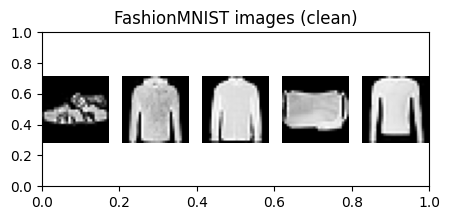

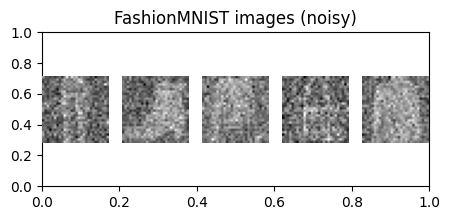

In [11]:
# Plot 5 training images for trainloader and trainloader_noise - no labels
# Set the number of images to plot
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (clean)')
# place it on GPU if available
dataiter = iter(trainloader) 
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from trainloader_noise
dataiter_noise = iter(trainloader_noise)  # Create an iterator for trainloader_noise
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (noisy)')
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter_noise)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from testloader
plt.show()

### Task 1: Implement a Linear Autoencoder 

In [12]:

class Encoder(nn.Module):
    """Encoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(np.prod(input_shape), 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 8),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    """Decoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.decoder = nn.Sequential(
            nn.Linear(8, 8),  #(8, 16)
            nn.ReLU(True),
            nn.Linear(8, 32), #(16, 32)
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, np.prod(input_shape)), 
            nn.Tanh(), # mapping output to -1, 1 range
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    """ Linear Autoencoder Network"""

    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [13]:
# 1.1 Implement a fully-connected autoencoder using the class torch.nn.Module2 from pytorch. Use the provided starter code as a template
autoencoder = Autoencoder(input_shape=(28, 28))
autoencoder.to(device)

print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU(inplace=True)
      (8): Linear(in_features=16, out_features=8, bias=True)
      (9): ReLU(inplace=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=32, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=32, out_features=64, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=64, out_features=128, bias=True)
      (7): ReLU(inplace=True)
      (8): Linear(in_features=128, out_features=784

In [14]:
def plot_samples(samples, path='img.png', figsize=(15, 6)):
    """ Plot 10 samples with their reconstructions """
    n_samples = len(samples)
    fig, axes = plt.subplots(2, n_samples, figsize=figsize) 
    axes = axes.flatten()
    fig.suptitle('Input Samples and their Reconstructions')

    for i, (input_img, reconstructed_img) in enumerate(samples):
        # Plot the input image
        axes[i].imshow(input_img.numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Input Image {i+1}', fontsize=7)

        # Plot the reconstructed image
        axes[i+n_samples].imshow(reconstructed_img.numpy().squeeze(), cmap='gray')
        axes[i+n_samples].axis('off')
        axes[i+n_samples].set_title(f'Reconstructed Image {i+1}', fontsize=7)

    plt.subplots_adjust(wspace=0.1) 
    plt.savefig(path)
    plt.show()

In [15]:
# 1.2 Use the mean squared error3 to implement the reconstruction error of the autoencoder.
# Train loop
def train(model, train_loader, optimizer, criterion, epoch, noise=False, device='cpu'):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # reshape to vector
        data = data.view(data.size(0), -1)
        data = data.to(device)

        # added noise to the inputs
        if noise:
            # mean square error with tanh activation in output - values are restricted to range [-1, 1]
            inputs_in = data.clone()
            inputs_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            inputs_in = data

        # forward pass: evaluate with model
        outputs = model(inputs_in)
        loss = criterion(outputs, data)
        
        # backward pass: compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update weights

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return model


# Test loop
def test(model, test_loader, noise=False, show_plot=False, device='cpu'):
    model.eval()
    test_loss = 0

    for i, (data, target) in enumerate(test_loader):
        # reshape to vector
        data = data.view(data.size(0), -1)
        data = data.to(device)

        # added noise to the inputs
        if noise:
            # mean square error with tanh activation in output - values are restricted to range [-1, 1]
            inputs_in = data.clone()
            inputs_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            inputs_in = data
        # forward pass: evaluate with model
        outputs = model(inputs_in)
        test_loss += nn.MSELoss(size_average=False)(outputs, data).item() # sum up batch loss

        if show_plot == 1 and i == 0:
            inp = make_grid(to_img(inputs_in.cpu().data))
            out = make_grid(to_img(outputs.cpu().data))
            target = make_grid(to_img(data.cpu().data))
            if noise:
                plt.imshow(transforms.ToPILImage()(inp))
                plt.axis('off')
                plt.show()
            plt.imshow(transforms.ToPILImage()(out))
            plt.axis('off')
            plt.show()
            plt.imshow(transforms.ToPILImage()(target))
            plt.axis('off')
            plt.show()
    
    # calculate average loss per epoch
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
        
    return test_loss


In [16]:
# Use mean squared error loss as reconstruction loss
criterion = nn.MSELoss() # MSE loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.673502
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.260889
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.171796
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.161033
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.145886


/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


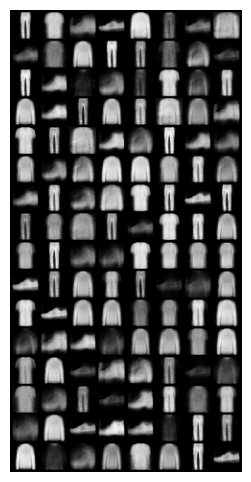

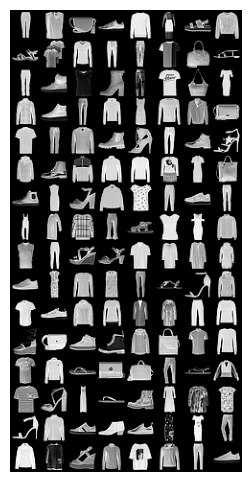


Test set: Average loss: 105.7446

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.133524
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.135281
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116114
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.123514
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.108753

Test set: Average loss: 89.2444

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.112410
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.115313
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.109968
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.118305
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.107191

Test set: Average loss: 84.3155

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.114608
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.095938
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.101899
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.099486
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.106893

Test set: Average loss: 81.6652

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.099495
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.107277
Train Epoch: 5 [25600/60000 (43%)

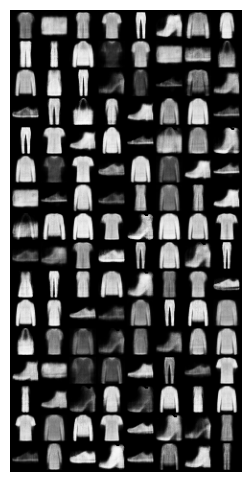

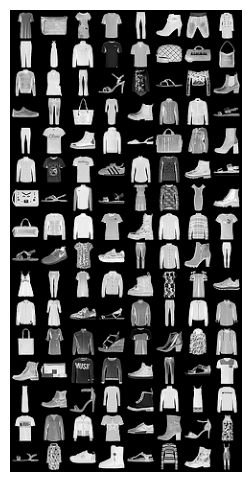


Test set: Average loss: 67.6753

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.086161
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.087224
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.085939
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.082864
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.078251

Test set: Average loss: 67.1796

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.093785
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.092826
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.084583
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.083800
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.087747

Test set: Average loss: 66.8297

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.082111
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.077620
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.084053
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.090204
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.082107

Test set: Average loss: 67.3388

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.085901
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.080701
Train Epoch: 15 [

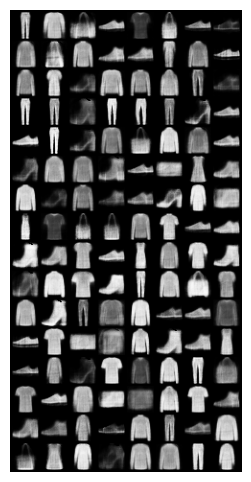

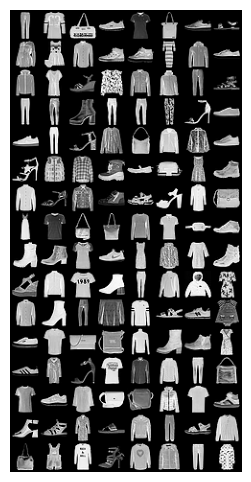


Test set: Average loss: 61.4885

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.080208
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.081384
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.076150
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.079111
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.076927

Test set: Average loss: 60.8165

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.073476
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.071822
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.074900
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.075619
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.071065

Test set: Average loss: 60.1467

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.070821
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.081806
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.079943
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.084587
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.081990

Test set: Average loss: 60.3361

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.070051
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.073361
Train Epoch: 25 [

In [17]:
# 1.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128. 
# -- Run it for at least 50 epochs.
lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = False

# initialize optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(autoencoder.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(autoencoder.state_dict(), 'best_fc_autoencoder.pth')

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))

In [18]:
def plot_latent(autoencoder, data, num_batches=128, path='latent.png', figsize=(4, 3), device='cpu'):
    z_list = []
    y_list = []
    
    autoencoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            if i >= num_batches:
                break
            z = autoencoder.encoder(x.to(device))
            z_list.append(z.cpu().numpy())
            y_list.append(y.numpy())
    
    z = np.concatenate(z_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space')
    plt.savefig(path)
    plt.show()

In [27]:
# Plot the latent space
plot_latent(autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent.png', device=device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x128)

In [28]:
# Report the training and validation loss of the autoencoder every ten epochs.
def plot_loss(test_losses, label='Loss curve',figsize=(5, 4), path='loss.png'):
    """ Plot test and training loss into the same plot """
    
    plt.figure(figsize=figsize)  # set the figure size
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.savefig(path)
    plt.show()

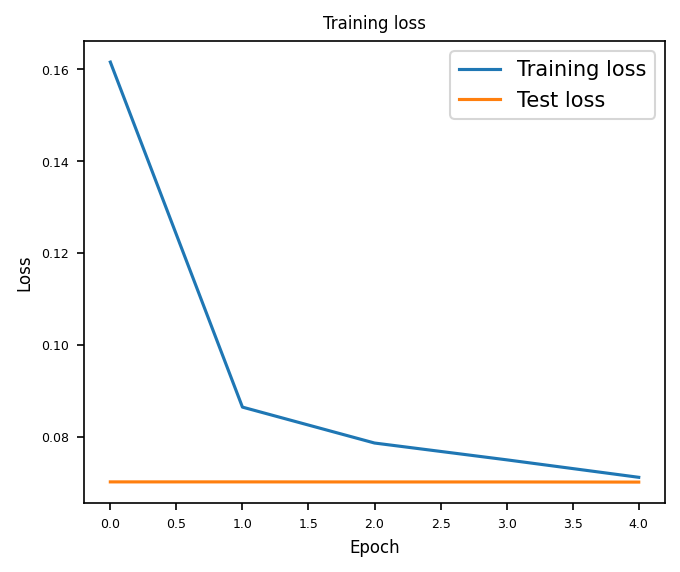

In [ ]:
plot_loss(test_losses, label='Linear AE - Loss Curve', path=RESULTS_DIR+'ae_loss_curve.png')

## Task 2: Denoising Autoencoders

2.1 Use your code for the previous task. The model stays the same. But instead of the original input apply your network to the noised input (see function add noise in network.py)

In [ ]:
# Note that you should still count loss between not noised image and your prediction.
# Compute the testing loss

lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = False

# initialize model
denoise_autoencoder = Autoencoder()
denoise_autoencoder.to(device)

# Initialize the optimizer
optimizer = torch.optim.Adam(denoise_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(autoencoder.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(autoencoder.state_dict(), 'best_fc_autoencoder.pth')

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


Epoch 1/5, Loss: 1.0441, Time: 5.58 sec
Epoch 2/5, Loss: 1.0445, Time: 5.31 sec
Epoch 3/5, Loss: 1.0442, Time: 5.22 sec
Epoch 4/5, Loss: 1.0445, Time: 5.26 sec
Epoch 5/5, Loss: 1.0445, Time: 5.26 sec


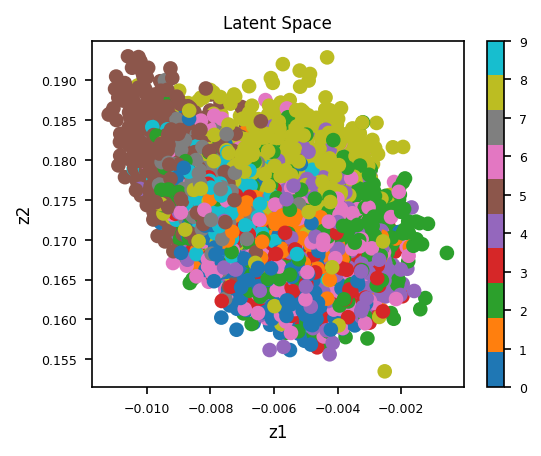

In [ ]:
# Plot the latent space
plot_latent(denoise_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent_with_noise.png', device=device)

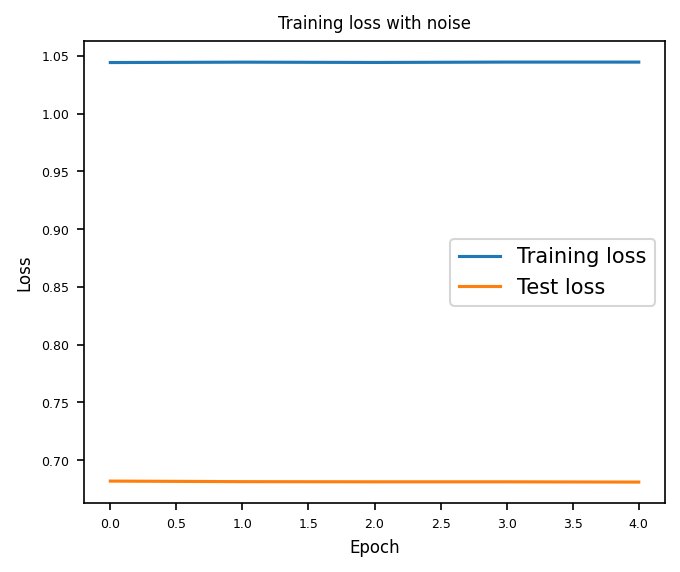

In [ ]:
# Plot the loss curve
plot_loss(test_losses, label='Linear Denoising AE - Loss Curve', path=RESULTS_DIR+'ae_loss_curve_with_noise.png')

**Describe how has the performance of the model changed.**

The linear encoder-decoder network demonstrates the ability to effectively encode by transformation the salient information of the input data into a lower-dimensional latent space, Z, through transformations. This results in good preliminary outcomes, often visible in less than 30 epochs. However, it is also noticeable that the results can be blurry and lack certain details. This might be a consequence of the loss function used, as the Mean Squared Error (MSE) loss tries to minimize the difference between the output and input of the network on a pixel level.

MSE loss is highly sensitive to outliers and large errors. In order to minimize the MSE loss, the model tends to focus on reducing these large errors first, often at the expense of preserving high-frequency details, such as edges, textures, and patterns, in the images. These high-frequency components are crucial for the perception of image sharpness and quality. Moreover, the MSE loss function assumes that the errors are independent and identically distributed (i.i.d.), which might not be the case for images. In natural images, the pixels are highly correlated with their neighbors, and these spatial dependencies are not explicitly considered by the MSE loss.

In contrast, the denoising autoencoder appears to struggle with learning how to recover the underlying structures of the data in order to minimize loss. The denoising autoencoder is a modification designed to prevent the network from simply learning an identity function, where the input and output are the same. This issue can arise when the encoder is too large and powerful, causing it to memorize the data instead of performing meaningful representation learning or dimensionality reduction.

Adding noise to the data can be seen as a form of regularization, encouraging the encoder to capture the salient features of the input data without resorting to memorization. However, the results of this experiment have not shown the expected improvements. This could be due to the choice of optimizer, the loss function, or potential issues in the implementation of the concatenation and subsequent clipping of noise and original data. Further investigation is needed to determine the cause and identify potential solutions, such as exploring alternative loss functions

## Task 3: Implement a Convolutional Autoencoder

In [22]:

class ConvEncoder(nn.Module):
    """ Convolutional Encoder network for the Autoencoder"""

    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(4), # added batch normalization
            nn.Conv2d(4, 8, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(8),
            nn.Flatten(),
            nn.Linear(3200, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class ConvDecoder(nn.Module):
    """ Convolutional Decoder network for the Autoencoder"""

    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.LeakyReLU(0.1),
            nn.Linear(400, 4000),
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class ConvAutoencoder(nn.Module):
    """ Convolutional Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(ConvAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        z = self.encoder(x)
        x = self.decoder(z)
        return x.view(-1, 1, self.input_shape[0], self.input_shape[1])

In [23]:
# 3.1 mplement a convolutional autoencoder using the class torch.nn.Module4 from pytorch. Use the provided starter code as a template.
conv_autoencoder = ConvAutoencoder().to(device)
print(conv_autoencoder)

ConvAutoencoder(
  (encoder): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
      (4): LeakyReLU(negative_slope=0.1)
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3200, out_features=10, bias=True)
      (8): Softmax(dim=1)
    )
  )
  (decoder): ConvDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=400, out_features=4000, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Unflatten(dim=1, unflattened_size=(10, 20, 20))
      (5): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (6): Bat

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.077799
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.072271
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073700
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.071181
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.071739


/Users/janinaalicamattes/miniforge3/envs/pytorch-py11/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


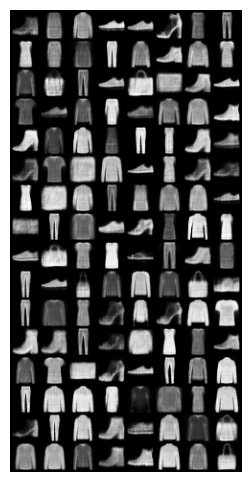

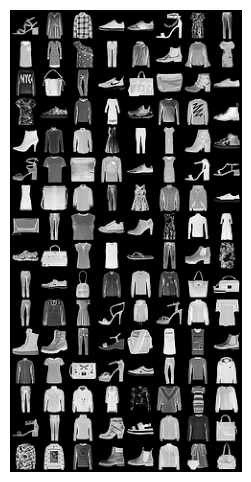


Test set: Average loss: 58.2858

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.070288
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.072971
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.074705
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.075639
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.073963

Test set: Average loss: 58.2858

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.073860
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.077128
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.070131
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.075252
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.076333

Test set: Average loss: 58.2858

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.069701
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.070990
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.068569
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.074120
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.067321

Test set: Average loss: 58.2858

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.073173
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.066926
Train Epoch: 5 [25600/60000 (43%)]

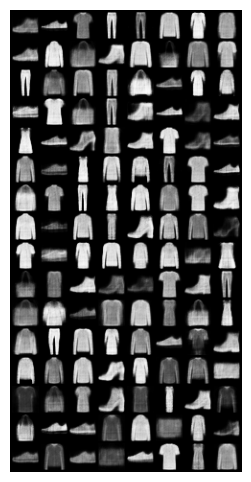

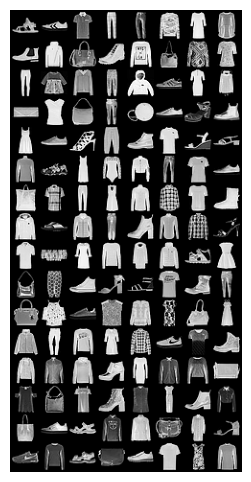


Test set: Average loss: 58.2858

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.076812
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.073536
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.072016
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.073085
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.073951

Test set: Average loss: 58.2858

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.073960
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.080310
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.068330
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.075221
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.073696

Test set: Average loss: 58.2858

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.073588
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.072563
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.083723
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.077724
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.072864

Test set: Average loss: 58.2858

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.071586
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.072118
Train Epoch: 15 [

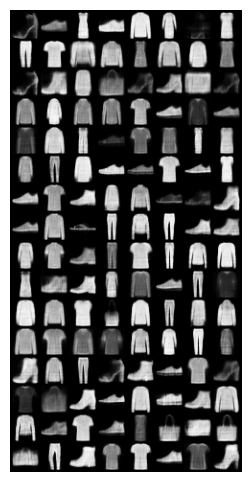

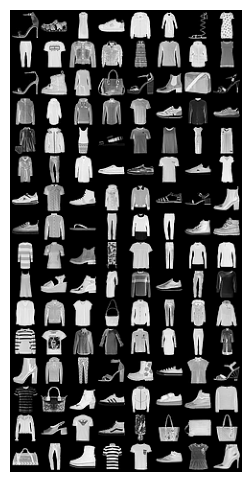


Test set: Average loss: 58.2858

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.073481
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.071529
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.077508
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.072970
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.069496

Test set: Average loss: 58.2858

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.069294
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.079223
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.076282
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.079278
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.076534

Test set: Average loss: 58.2858

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.071222
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.068930
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.070615
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.069305
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.080422

Test set: Average loss: 58.2858

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.080376
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.070843
Train Epoch: 25 [

In [24]:
# 5. Report the loss on the training split for each epoch, and every ten epochs on the test set
lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = False

# Initialize the optimizer
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(autoencoder.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(autoencoder.state_dict(), 'best_fc_autoencoder.pth')

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


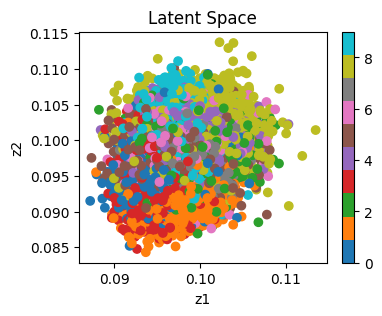

In [25]:
# Plot the latent space
plot_latent(conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent.png', device=device)

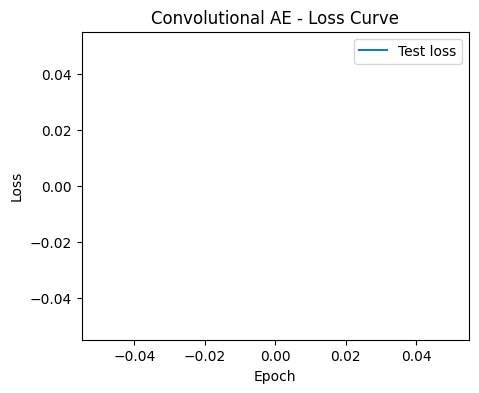

In [29]:
# Plot the loss curve
plot_loss(test_losses, label='Convolutional AE - Loss Curve', path=RESULTS_DIR+'aeconv_loss_curve.png')

**3.5 Compare the performance of this model to the model from the prior task**

* The model with Convolutional Layers demonstrates a greater capacity for learning patterns from high-dimensional, 2D spatial data, as the learned filters in a convolutional neural network are designed to recognize more complex local patterns. In contrast, linear models are less equipped to handle this task.
* Upon visualizing the learned lower-dimensional latent space Z of the encoder with linear layers, it is evident that the latent space scatter plots per class exhibit a linear structure. This suggests that the linear encoder also primarily captures linear relationships in the data.
* In contrast, when examining the components of the latent space of the convolutional encoder, it is clear that the convolutional layers have facilitated a more effective projection of the encoded input values into the latent space. The presence of distinct, separable clusters in the convolutional encoder's latent space indicates that this model is able to capture more complex, non-linear relationships in the data.
* Furthermore, the expressiveness and capacity of the convolutional encoder are shown to be superior to the linear encoder. This may be due to the limitations of a linear transformation when mapping input data into the latent space, where the relationship between the input features and the latent space is strictly linear. As a result, each class is also only represented by a linearly separable region, which may not reflect the true underlying patterns in the input data. The convolutional encoder, however, is not restricted by such linear assumptions and is therefore more capable of transforming the input data into a non-linear latent space. The result visible in the training and testing loss curve is also reflected in the reconstruction of the decoder, which shows higher capacity to reconstruct output images close to the input data distribution than the linear encoder.

## Denoising Convolutional Autoencoder

In [ ]:
# train the model with noise
denoise_conv_autoencoder = ConvAutoencoder()
denoise_conv_autoencoder.to(device)

In [ ]:
# 5. Report the loss on the training split for each epoch, and every ten epochs on the test set
lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = True

# Initialize the optimizer
optimizer = torch.optim.Adam(denoise_conv_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(autoencoder.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(autoencoder.state_dict(), 'best_fc_autoencoder.pth')

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


KeyboardInterrupt: 

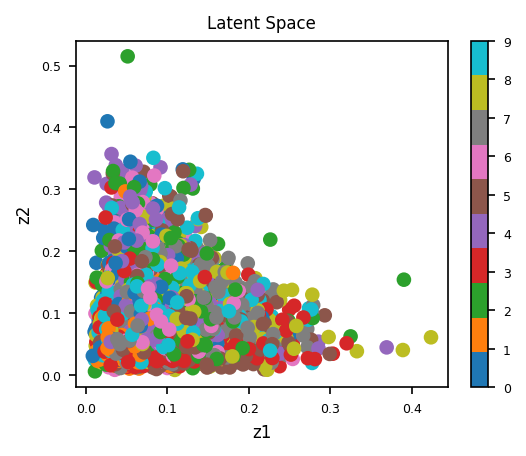

In [ ]:
# Plot the latent space
plot_latent(denoise_conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent_with_noise.png', device=device)

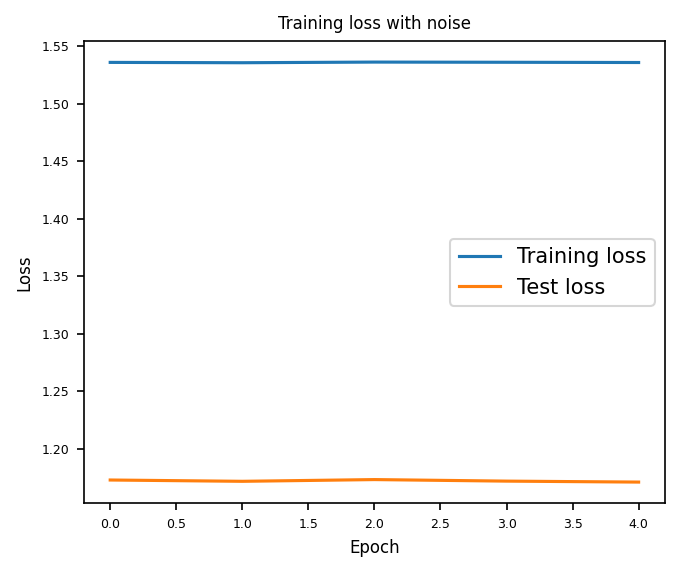

In [ ]:
# Plot the loss curve
plot_loss(test_losses, label='Convolutional Denoising AE - Loss Curve', path=RESULTS_DIR+'aeconv_loss_curve_with_noise.png')